In [17]:
import os
import numpy as np  
from PIL import Image
import tensorflow as tf 
from keras import backend as K           
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import sklearn.metrics as metrics
from keras.models import load_model
from skimage.transform import resize
from keras.preprocessing import image  
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.metrics import roc_auc_score

## Load dataset

In [2]:
folder_benign_train = r'C:\Users\11609\Desktop\sem1\ML\cw\cousework2\archive\train\benign'
folder_malignant_train = r'C:\Users\11609\Desktop\sem1\ML\cw\cousework2\archive\train\malignant'

folder_benign_test = r'C:\Users\11609\Desktop\sem1\ML\cw\cousework2\archive\test\benign'
folder_malignant_test = r'C:\Users\11609\Desktop\sem1\ML\cw\cousework2\archive\test\malignant'

In [3]:
# Load in training pictures 
ims_benign = [Image.open(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array([np.array(im) for im in ims_benign])

ims_malignant = [Image.open(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array([np.array(im) for im in ims_malignant])
# Create labels for training data
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

# Load in testing pictures 
ims_benign_test = [Image.open(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array([np.array(im) for im in ims_benign_test])

ims_malignant_test = [Image.open(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array([np.array(im) for im in ims_malignant_test])
# Create labels for testing data

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

In [4]:
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

## data splitting

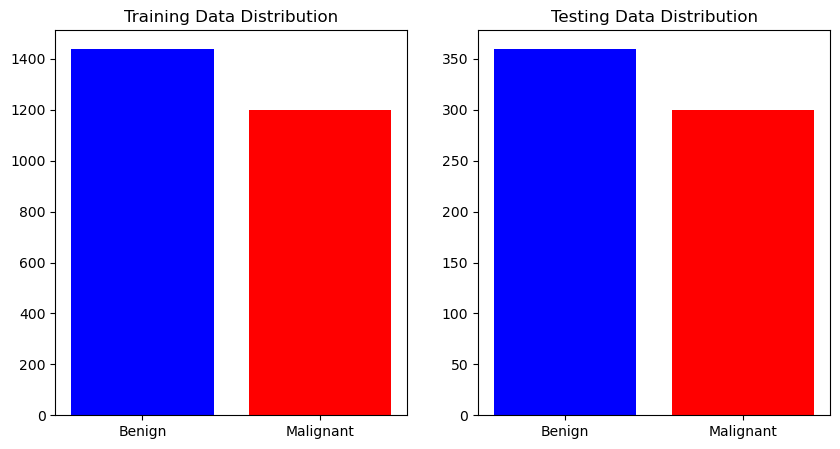

In [5]:
train_benign_count = np.sum(y_train == 0)
train_malignant_count = np.sum(y_train == 1)
test_benign_count = np.sum(y_test == 0)
test_malignant_count = np.sum(y_test == 1)
labels = ['Benign', 'Malignant']
train_counts = [train_benign_count, train_malignant_count]
test_counts = [test_benign_count, test_malignant_count]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.bar(labels, train_counts, color=['blue', 'red'])
ax1.set_title('Training Data Distribution')
ax2.bar(labels, test_counts, color=['blue', 'red'])
ax2.set_title('Testing Data Distribution')
plt.show()

## dataset processing 

In [6]:
# random data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

## Ensemble ANN model

In [7]:
def preprocess_image(img):
    # Grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Binarization
    _, binary_img = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY)
    
    return binary_img
# train set
X_train_processed = np.array([preprocess_image(img) for img in X_train])

# test set
X_test_processed = np.array([preprocess_image(img) for img in X_test])

## Defined Lost

In [8]:
# Custom Sparse Categorical Crossentropy Loss
def custom_sparse_categorical_crossentropy(y_true, y_pred):
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)
    penalty = 0.01
    total_loss = loss + penalty
    return total_loss

# Custom Loss V2
def custom_loss_v2(y_true, y_pred):
    mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    new_penalty = 0.01
    total_loss = mse_loss + new_penalty
    return total_loss

def custom_binary_crossentropy(y_true, y_pred):
    epsilon = 1e-15  # Small constant to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Clip predicted probabilities to avoid log(0)
    
    # Binary Crossentropy Loss Calculation
    loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    return np.mean(loss)

In [9]:
def calculate_accuracy(predictions, labels):
    accuracy = np.mean(np.round(predictions) == labels)
    return accuracy

In [10]:
def calculate_accuracy(predictions, labels):
    accuracy = np.mean(np.round(predictions) == labels)
    return accuracy

def calculate_precision(labels, predictions):
    true_positives = np.sum((predictions == 1) & (labels == 1))
    false_positives = np.sum((predictions == 1) & (labels == 0))
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    return precision

def calculate_recall(labels, predictions):
    true_positives = np.sum((predictions == 1) & (labels == 1))
    false_negatives = np.sum((predictions == 0) & (labels == 1))
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    return recall

def calculate_f1(labels, predictions):
    precision = calculate_precision(labels, predictions)
    recall = calculate_recall(labels, predictions)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return f1

def calculate_specificity(labels, predictions):
    true_negatives = np.sum((predictions == 0) & (labels == 0))
    false_positives = np.sum((predictions == 1) & (labels == 0))
    specificity = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0
    return specificity

def calculate_false_positive_rate(labels, predictions):
    return 1 - calculate_specificity(labels, predictions)

def calculate_false_negative_rate(labels, predictions):
    true_positives = np.sum((predictions == 1) & (labels == 1))
    false_negatives = np.sum((predictions == 0) & (labels == 1))
    fnr = false_negatives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    return fnr

def calculate_roc_auc(labels, predictions):
    # You need to implement ROC AUC calculation, this is just a placeholder
    roc_auc = 0.5
    return roc_auc

def calculate_balanced_accuracy(labels, predictions):
    sensitivity = calculate_recall(labels, predictions)
    specificity = calculate_specificity(labels, predictions)
    balanced_accuracy = (sensitivity + specificity) / 2
    return balanced_accuracy

In [11]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

# Define custom combined loss
def custom_combined_loss(y_true, y_pred):
    binary_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    penalty = 0.01  # regularization penalty
    
    total_loss = binary_loss + mse_loss + penalty
    return total_loss

# Assuming y_train is one-dimensional (e.g., [0, 1, 0, 1, ...])
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)
X_train_flatten = X_train_processed.reshape((X_train_processed.shape[0], -1))

# Define and compile the model
model_binary_crossentropy = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_flatten.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(2, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=9e-7)
model_binary_crossentropy.compile(optimizer=optimizer, loss=custom_combined_loss)

# Define a predict_proba_fn for SHAP explainer
def predict_proba_fn(x):
    return model_binary_crossentropy.predict(x)

# Train the model
history_binary_crossentropy = model_binary_crossentropy.fit(X_train_flatten, y_train_one_hot, epochs=44, batch_size=32, validation_split=0.1)
pred_train_probs = model_binary_crossentropy.predict(X_train_flatten)
pred_train_labels = np.argmax(pred_train_probs, axis=1)
# Calculate accuracy on training data
train_accuracy = calculate_accuracy(pred_train_labels, y_train)
precision = calculate_precision(y_train, pred_train_labels)
recall = calculate_recall(y_train, pred_train_labels)
f1 = calculate_f1(y_train, pred_train_labels)
specificity = calculate_specificity(y_train, pred_train_labels)
fpr = calculate_false_positive_rate(y_train, pred_train_labels)
fnr = calculate_false_negative_rate(y_train, pred_train_labels)
roc_auc = calculate_roc_auc(y_train, pred_train_probs[:, 1])
balanced_accuracy = calculate_balanced_accuracy(y_train, pred_train_labels)
print("Training Accuracy:", train_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Specificity:", specificity)
print("False Positive Rate:", fpr)
print("False Negative Rate:", fnr)
print("ROC AUC Score:", roc_auc)
print("Balanced Accuracy:", balanced_accuracy)

Epoch 1/44
75/75 [==============================] - 4s 11ms/step - loss: 11.8237 - val_loss: 8.4042
Epoch 2/44
75/75 [==============================] - 0s 6ms/step - loss: 6.7752 - val_loss: 7.2571
Epoch 3/44
75/75 [==============================] - 0s 6ms/step - loss: 5.5955 - val_loss: 6.3281
Epoch 4/44
75/75 [==============================] - 0s 6ms/step - loss: 4.8324 - val_loss: 5.7761
Epoch 5/44
75/75 [==============================] - 0s 6ms/step - loss: 4.3519 - val_loss: 5.2951
Epoch 6/44
75/75 [==============================] - 0s 6ms/step - loss: 3.9812 - val_loss: 4.9875
Epoch 7/44
75/75 [==============================] - 0s 5ms/step - loss: 3.6705 - val_loss: 4.8282
Epoch 8/44
75/75 [==============================] - 0s 6ms/step - loss: 3.3986 - val_loss: 4.6306
Epoch 9/44
75/75 [==============================] - 0s 5ms/step - loss: 3.2033 - val_loss: 4.7763
Epoch 10/44
75/75 [==============================] - 0s 5ms/step - loss: 3.0014 - val_loss: 4.4625
Epoch 11/44
75/75

Epoch 1/44
75/75 [==============================] - 1s 10ms/step - loss: 15.2273 - val_loss: 8.9053
Epoch 2/44
75/75 [==============================] - 0s 5ms/step - loss: 7.8459 - val_loss: 7.3986
Epoch 3/44
75/75 [==============================] - 0s 5ms/step - loss: 6.3860 - val_loss: 6.6871
Epoch 4/44
75/75 [==============================] - 0s 6ms/step - loss: 5.7012 - val_loss: 6.3292
Epoch 5/44
75/75 [==============================] - 0s 5ms/step - loss: 5.1324 - val_loss: 5.7752
Epoch 6/44
75/75 [==============================] - 0s 6ms/step - loss: 4.7812 - val_loss: 5.7210
Epoch 7/44
75/75 [==============================] - 0s 5ms/step - loss: 4.4199 - val_loss: 5.4156
Epoch 8/44
75/75 [==============================] - 0s 5ms/step - loss: 4.1166 - val_loss: 5.3945
Epoch 9/44
75/75 [==============================] - 0s 5ms/step - loss: 3.9037 - val_loss: 5.4607
Epoch 10/44
75/75 [==============================] - 0s 5ms/step - loss: 3.7042 - val_loss: 5.2071
Epoch 11/44
75/75

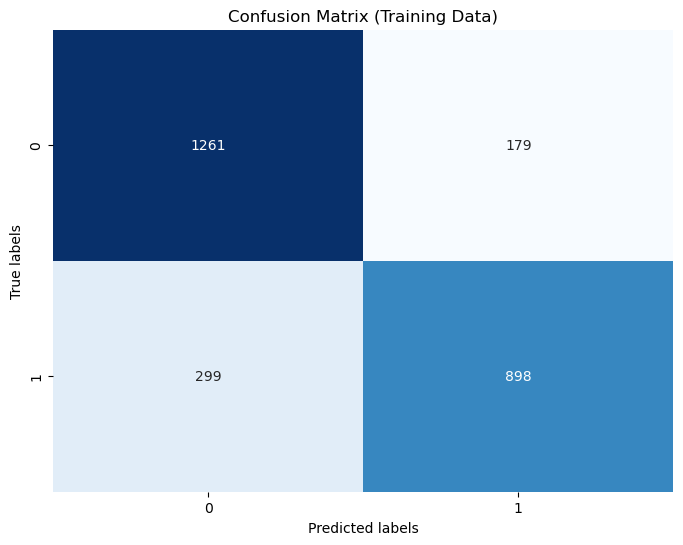

Training Accuracy: 0.8187334091770951
Precision: 0.8337975858867224
Recall: 0.7502088554720133
F1 Score: 0.7897977132805628
ROC AUC Score: 0.8661712150747238


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns

# Define custom combined loss function
def custom_combined_loss(y_true, y_pred):
    binary_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    penalty = 0.01  # regularization penalty
    total_loss = binary_loss + mse_loss + penalty
    return total_loss

# Assuming y_train is one-dimensional (e.g., [0, 1, 0, 1, ...])
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)
X_train_flatten = X_train_processed.reshape((X_train_processed.shape[0], -1))

# Define and compile the model
model_binary_crossentropy = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_flatten.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(2, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=9e-7)
model_binary_crossentropy.compile(optimizer=optimizer, loss=custom_combined_loss)

# Train the model
history_binary_crossentropy = model_binary_crossentropy.fit(X_train_flatten, y_train_one_hot, epochs=44, batch_size=32, validation_split=0.1)

# Predictions on training data
pred_train_probs = model_binary_crossentropy.predict(X_train_flatten)
pred_train_labels = np.argmax(pred_train_probs, axis=1)

# Calculate confusion matrix on training data
conf_matrix_train = confusion_matrix(y_train, pred_train_labels)
print("Confusion Matrix (Training Data):")
print(conf_matrix_train)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix (Training Data)")
plt.show()

# Calculate performance metrics on training data
train_accuracy = accuracy_score(y_train, pred_train_labels)
precision = precision_score(y_train, pred_train_labels)
recall = recall_score(y_train, pred_train_labels)
f1 = f1_score(y_train, pred_train_labels)
roc_auc = roc_auc_score(y_train, pred_train_probs[:, 1])

print("Training Accuracy:", train_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

  0%|          | 0/100 [00:00<?, ?it/s]

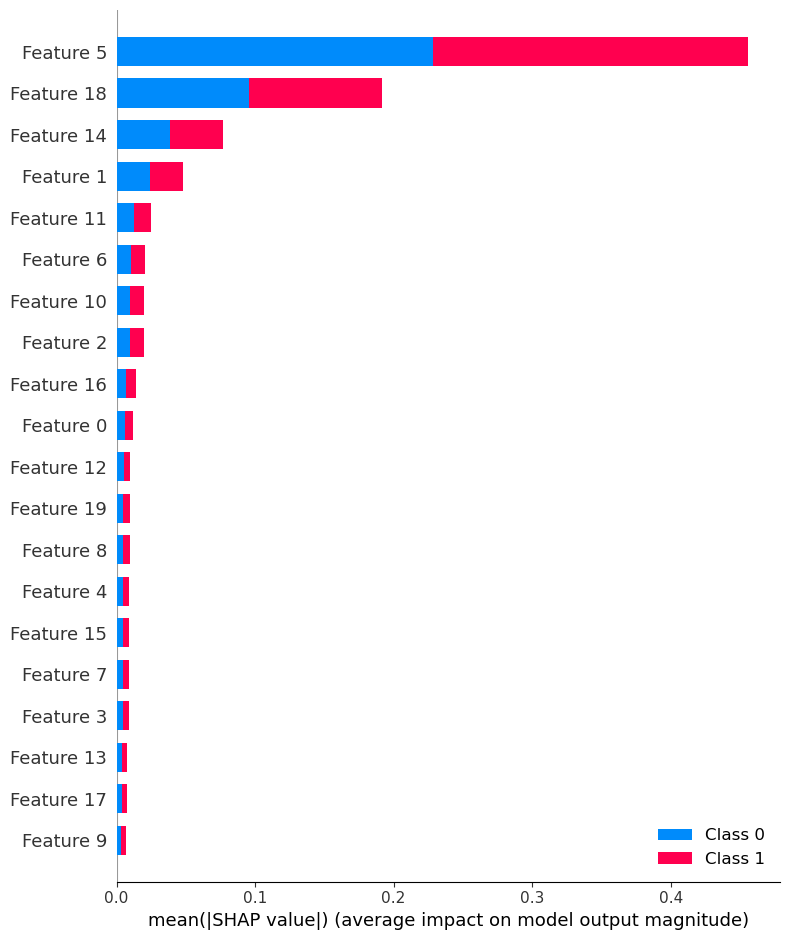

In [15]:
import shap
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# Generate some sample data for demonstration
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train your model (assuming you have defined model_binary_crossentropy and y_train_one_hot)
model_binary_crossentropy = RandomForestClassifier()
model_binary_crossentropy.fit(X_train, y_train)

# Flatten X_test
X_test_flattened = X_test.reshape((X_test.shape[0], -1))

# Define a predict function for the explainer
predict_fn = model_binary_crossentropy.predict_proba

# Generate background_summary with the same number of features as x_test_sample
background_summary = shap.sample(X_train, 10)

# Initialize the explainer
explainer = shap.KernelExplainer(predict_fn, background_summary)

# Sample a subset of data for explanation
x_test_sample = shap.sample(X_test, 100)

# Compute SHAP values
shap_values_model = explainer.shap_values(x_test_sample)

# Plot SHAP values
shap.summary_plot(shap_values_model, x_test_sample, feature_names=None) 

In [16]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)
X_train_flatten = X_train_processed.reshape((X_train_processed.shape[0], -1))

# Build the model
model_binary_crossentropy = Sequential()
model_binary_crossentropy.add(Dense(128, activation='relu', input_shape=(X_train_flatten.shape[1],)))
model_binary_crossentropy.add(Dense(64, activation='relu'))
model_binary_crossentropy.add(Dense(32, activation='relu'))
model_binary_crossentropy.add(Dense(1, activation='sigmoid'))

# Compile the model without using 'accuracy' metric
optimizer = tf.keras.optimizers.Adam(learning_rate=9e-7)
model_binary_crossentropy.compile(optimizer=optimizer, loss=custom_binary_crossentropy)

# Train the model
history = model_binary_crossentropy.fit(X_train_flatten, y_train_one_hot, epochs=44, batch_size=16, validation_split=0.1)

# Predictions on training data
pred_train_probs = model_binary_crossentropy.predict(X_train_flatten)
pred_train_labels = (pred_train_probs > 0.5).astype(int)  # Convert probabilities to labels
accuracy_train = accuracy_score(y_train, pred_train_labels)
print("Training Accuracy:", accuracy_train)

# Generate dummy test data
X_test_processed = np.random.random((200, 10))
y_test = np.random.randint(2, size=(200,))
X_test_flatten = X_test_processed.reshape((X_test_processed.shape[0], -1))

# Predictions on test data
pred_test_probs = model_binary_crossentropy.predict(X_test_flatten)
pred_test_labels = (pred_test_probs > 0.5).astype(int)  # Convert probabilities to labels
accuracy_test = accuracy_score(y_test, pred_test_labels)
print("Test Accuracy:", accuracy_test)

# Calculate confusion matrix for test data
conf_matrix_test = confusion_matrix(y_test, pred_test_labels)

print("Confusion Matrix (Training Data):")
print(conf_matrix_train)

# Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix (Test Data)")
plt.show()

precision = calculate_precision(y_test, pred_test_labels)
print("Test Accuracy:", accuracy_test)
print("Precision:", precision)
recall = calculate_recall(y_test, pred_test_labels)
print("Recall:", recall)
f1 = calculate_f1(y_test, pred_test_labels)
print("F1 Score:", f1)
specificity = calculate_specificity(y_test, pred_test_labels)
print("Specificity:", specificity)
fpr = calculate_false_positive_rate(y_test, pred_test_labels)
print("False Positive Rate:", fpr)
fnr = calculate_false_negative_rate(y_test, pred_test_labels)
print("False Negative Rate:", fnr)
roc_auc = calculate_roc_auc(y_test, pred_test_probs)
print("ROC AUC Score:", roc_auc)
balanced_accuracy = calculate_balanced_accuracy(y_test, pred_test_labels)
print("Balanced Accuracy:", balanced_accuracy)

Epoch 1/44


NotImplementedError: in user code:

    File "D:\work\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\11609\AppData\Local\Temp\ipykernel_14168\1546224512.py", line 17, in custom_binary_crossentropy  *
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Clip predicted probabilities to avoid log(0)
    File "D:\work\Anaconda\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py", line 2169, in clip  **
        return _wrapfunc(a, 'clip', a_min, a_max, out=out, **kwargs)
    File "D:\work\Anaconda\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py", line 56, in _wrapfunc
        return _wrapit(obj, method, *args, **kwds)
    File "D:\work\Anaconda\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py", line 45, in _wrapit
        result = getattr(asarray(obj), method)(*args, **kwds)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (sequential_5/dense_28/Sigmoid:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.
